## Plotting geospatial data : HMEI interns 2022
This is a short notebook describing how to *plot* some geospatial data using python.  
This notebook is based on data stored on the AOS machine *oahu*. For use on the GFDL PP/AN system, the directories of the data will need to be changed accordingly.

In [1]:
# Import the packages that you want to use
import xarray as xr
import nc_time_axis
import matplotlib.pyplot as plt

In [2]:
# Now plot
# Because this calculation will take a while, it can be useful to ensure that it's still chugging away
# For this we can use a convenient "progress bar"
from dask.diagnostics import ProgressBar

In [3]:
# Specify the path to the data on oahu
# Here, I specify the main "postprocess" path, which ends with the folder "pp"
rootdir = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/' + 'ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/'+
           'pp/')
# Then, I say which subset of postprocessed data 
# (different types of variables are sstored in different folders, 
# e.g. ocean physical variables like tmperature, or biogeochemical variables
# like chlorophyll)
ppname = 'ocean_month'
# Finally I specify some details of the local directory
localdir = '/ts/monthly/5yr/'

# Let's also load data on the "grid" - the spatial information about
# how and where the data are located on the world
# These are found in so-called "static" files within the pp subfolders
# and also
#COMMENTING THIS OUT FOR NOW
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

Point to and load the data

## Time-series data
Visualise the change of global mean SST over time.  
Not all grid points in a model have the same surface area, so when calculating averages, we need to do an area weighting.  

### Loading longer time-series
Our data are saved in groups of 5 years, hence that is the length of the time-series plotted above. However, we can load and concatenate multiple files all at once, to create, load, and plot longer time-series.  
This is very easy with `xarray`, where all we need to change in our loading procedure above is the `filename`, so that it includes a "wildcard" entry, and use the command `xr.open_mfdataset`, where `mf` stands for "multiple files".

In [4]:
# The wildcard entry * tells python to look for all files that match that pattern,
# where the * can be replaced by anything, of any length
# Here, I am going to load all data in the first century
filename = ppname+'*.tos.nc'
# Respecify the path (everything else is the same here)
path = rootdir+ppname+localdir+filename
print(path)
# Load the data
ds = xr.open_mfdataset(path)
# Chunk again
ds = ds.chunk({'time':60})
ds

/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month/ts/monthly/5yr/ocean_month*.tos.nc


<xarray.Dataset>
Dimensions:    (xh: 720, yh: 576, time: 3600, nv: 2, xq: 720, yq: 576, zl: 75)
Coordinates:
  * xh         (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh         (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time       (time) object 0101-01-16 12:00:00 ... 0400-12-16 12:00:00
  * nv         (nv) float64 1.0 2.0
  * xq         (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
  * yq         (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * zl         (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Data variables:
    tos        (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    time_bnds  (time, nv) object dask.array<chunksize=(60, 2), meta=np.ndarray>
Attributes:
    filename:          01010101.ocean_month.nc
    title:             ESM4_piControl_D
    associated_files:  areacello: 01010101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           2022-03-14 17:08:51 -0400: PostProcessing::PPNetCDF::t...

In [5]:
# Now do the area-weighted average
tos_mean = ds['tos'].weighted(grid['areacello']).mean(['xh','yh'])
tos_mean

<xarray.DataArray 'tos' (time: 3600)>
dask.array<truediv, shape=(3600,), dtype=float32, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0101-01-16 12:00:00 ... 0400-12-16 12:00:00

[########################################] | 100% Completed |  5.7s


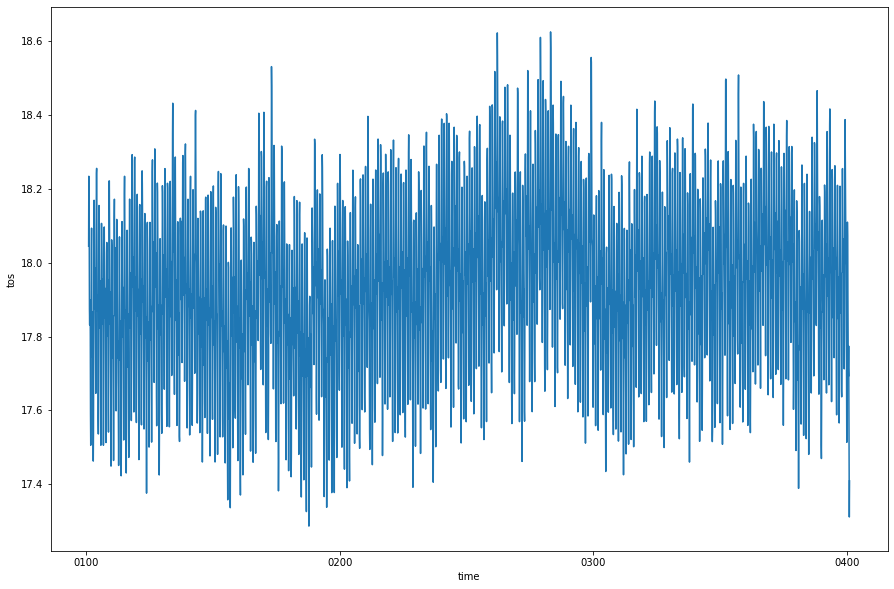

In [6]:
# Because we are going to make a number of further plots, 
# it can be useful to load the data into memory with `.compute`
# before plotting
with ProgressBar():
    tos_mean = tos_mean.compute()
tos_mean.plot(size=10)

In [7]:
def ens_mean(driver):
    ens_mean = [*range(10)] # create a list to store each ensemble, list is 1 indexed
    print(ens_mean)
    for ensemble in range(1,10):
        ensemble_path = '/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/' + 'ESM4_piControl_D-ensemble-*0' + str(ensemble) +'/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month/ts/monthly/5yr/'
        filename = '*'+driver+'.nc'
        ens_ds_tos = xr.open_mfdataset(ensemble_path+filename)
        ens_mean[ensemble] = ens_ds_tos[driver].weighted(grid['areacello']).mean(['xh','yh'])
        with ProgressBar():
            ens_mean[ensemble].compute()
    return ens_mean


In [8]:
tos_ens_mean = ens_mean('tos')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.0s


KeyboardInterrupt: 

In [ ]:
tos_ens_mean[2]

In [9]:
#beginning and end of time range must be passed as strings, plots just 1 ensemble member
def plot_range_single(tos_mean, ens_mean, beginning, end):
    tos_mean_slice = tos_mean.sel(time=slice(beginning, end))
    ens_mean_slice = ens_mean.sel(time=slice(beginning,end))
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    ax.plot(tos_mean_slice['time'],tos_mean_slice)
    ax.plot(ens_mean_slice['time'],ens_mean_slice,linestyle='dashed')
    #ax.plot((tos_mean-ens1_mean_tos)['time'],(tos_mean-ens1_mean_tos)+18)

In [10]:
#plots all ensemble members together
def plot_range_all(tos_mean, ens_mean, beginning='0100', end='0400',title='Time Series',update=False,ylabel='Sea Surface Temperature (deg C)'):
    tos_mean_slice = tos_mean.sel(time=slice(beginning, end))
    fig,ax = plt.subplots(1,1,figsize=(16,8))
    
    # Title and axes labels
    plt.title(title,fontsize=16)
    plt.xlabel('Time (Year)',fontsize=13)
    plt.ylabel(ylabel,fontsize=13)
    
    ax.plot(tos_mean_slice['time'],tos_mean_slice)
    for ensemble in range(1,10):
        ens_mean_slice = ens_mean[ensemble].sel(time=slice(beginning,end))
        ax.plot(ens_mean_slice['time'],ens_mean_slice,color='r',linestyle='dashed')
    if update:
        plt.savefig(title)

In [18]:
def plot_anomaly(tos_mean,ens_mean,beginning,end,title='Anomaly',update=False, ylabel='Sea Surface Temperature (deg C)'):
    tos_mean_slice = tos_mean.sel(time=slice(beginning, end))
    fig,ax = plt.subplots(1,1,figsize=(16,8))
    plt.title(title,fontsize=16)
    plt.xlabel('Time (Year)',fontsize=13)
    plt.ylabel(ylabel,fontsize=13)
    
    for ensemble in range(1,10):
        ens_mean_slice = ens_mean[ensemble].sel(time=slice(beginning,end))
        ax.plot((tos_mean_slice-ens_mean_slice)['time'],(tos_mean_slice-ens_mean_slice))
    if update:
        plt.savefig(title)

In [ ]:
plot_range_all(tos_mean,tos_ens_mean,'0208','0217','Global Mean SST of Control (Blue) and Ensembles (Red), Year 208')
plot_anomaly(tos_mean,tos_ens_mean,'0208','0220','Difference in Global Mean SST in 9 Ensemble Members Versus Control, Year 208')

to_netcdf look up how to make something anetcdf

In [ ]:
plot_range_all(tos_mean,tos_ens_mean,'0123','0132','Global Mean SST of Control (Blue) and Ensembles (Red), Year 123')
plot_anomaly(tos_mean,tos_ens_mean,'0123','0133','Difference in Global Mean SST in 9 Ensemble Members Versus Control, Year 123')

In [ ]:
plot_range_all(tos_mean,tos_ens_mean,'0359','0368','Global Mean SST of Control (Blue) and Ensembles (Red), Year 359')
plot_anomaly(tos_mean,tos_ens_mean,'0359','0369','Difference in Global Mean SST in 9 Ensemble Members Versus Control, Year 359')

In [13]:
def driver_mean(driver):
    # The wildcard entry * tells python to look for all files that match that pattern,
    # where the * can be replaced by anything, of any length
    # Here, I am going to load all data in the first century
    filename = ppname+'*'+driver+'*'
    print(filename)
    # Respecify the path (everything else is the same here)
    path = rootdir+ppname+localdir+filename
    # Load the data
    ds = xr.open_mfdataset(path)
    # Chunk again
    ds = ds.chunk({'time':60})
    
    mean = ds[driver].weighted(grid['areacello']).mean(['xh','yh'])
    with ProgressBar():
        mean = mean.compute()
    mean.plot(size=10)
    return mean

In [ ]:
sos_mean = driver_mean('sos')

In [ ]:
sos_ens_mean = ens_mean('sos')

In [ ]:
plot_range_all(sos_mean,sos_ens_mean,'0230','0239','Global Mean SSS of Control (Blue) and Ensembles (Red), Year 230',True,'Sea Surface Salinity (psu)')
plot_anomaly(sos_mean,sos_ens_mean,'0230','0240','Difference in Global Mean SSS in 9 Ensemble Members Versus Control, Year 230',True,'Sea Surface Salinity (psu)')

In [ ]:
plot_range_all(sos_mean,sos_ens_mean,'0300','0309','Global Mean SSS of Control (Blue) and Ensembles (Red), Year 300',True,'Sea Surface Salinity (psu)')
plot_anomaly(sos_mean,sos_ens_mean,'0300','0310','Difference in Global Mean SSS in 9 Ensemble Members Versus Control, Year 300',True,'Sea Surface Salinity (psu)')

In [ ]:
plot_range_all(sos_mean,sos_ens_mean,'0161','0170','Global Mean SSS of Control (Blue) and Ensembles (Red), Year 161',True,'Sea Surface Salinity (psu)')
plot_anomaly(sos_mean,sos_ens_mean,'0161','0171','Difference in Global Mean SSS in 9 Ensemble Members Versus Control, Year 161',True,'Sea Surface Salinity (psu)')

ocean_month*MLD_003*
[########################################] | 100% Completed |  5.5s


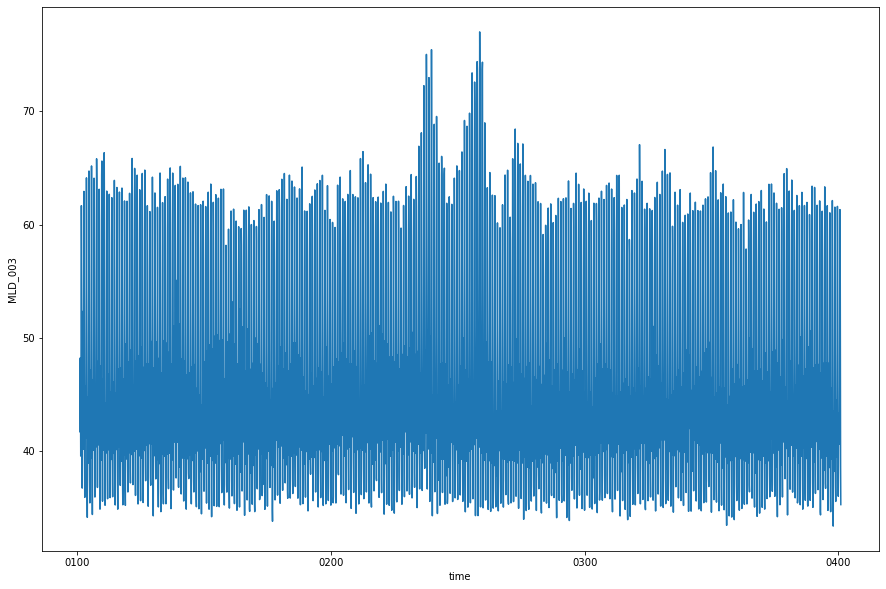

In [14]:
npp_mean = driver_mean('MLD_003')

In [15]:
npp_ens_mean = ens_mean('MLD_003')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s


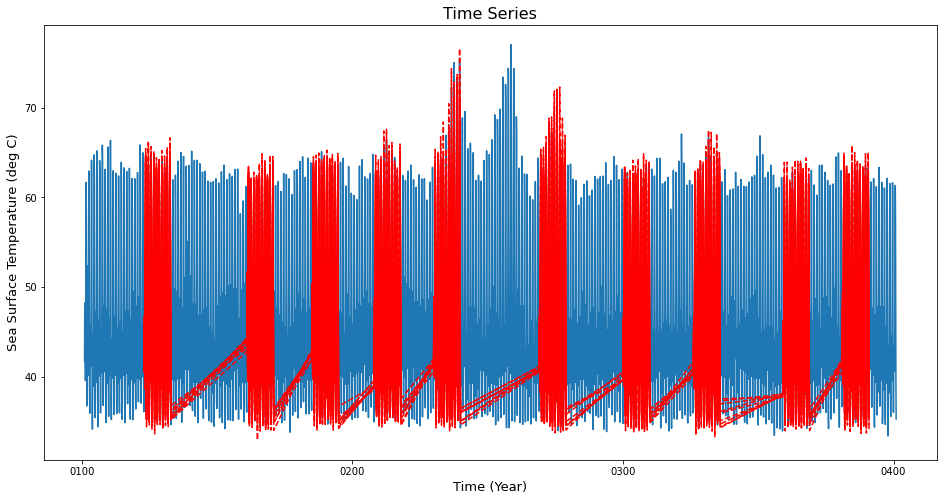

In [16]:
plot_range_all(npp_mean,npp_ens_mean)

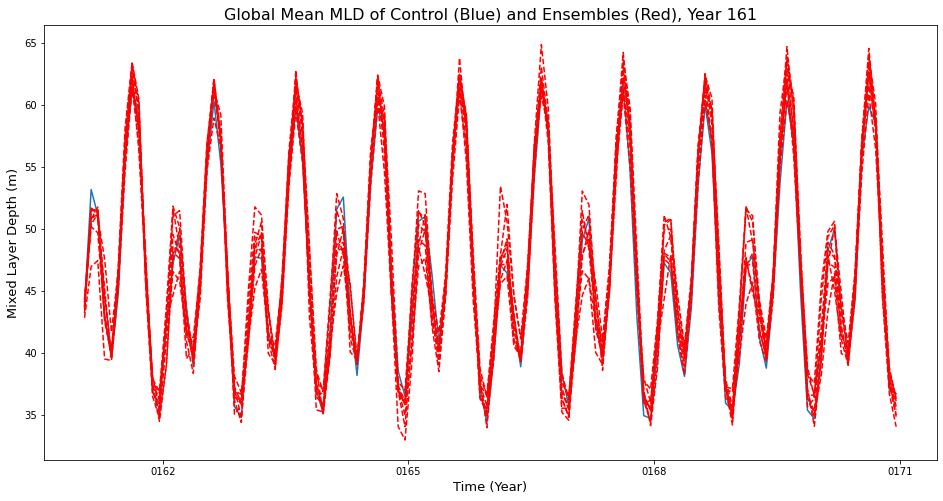

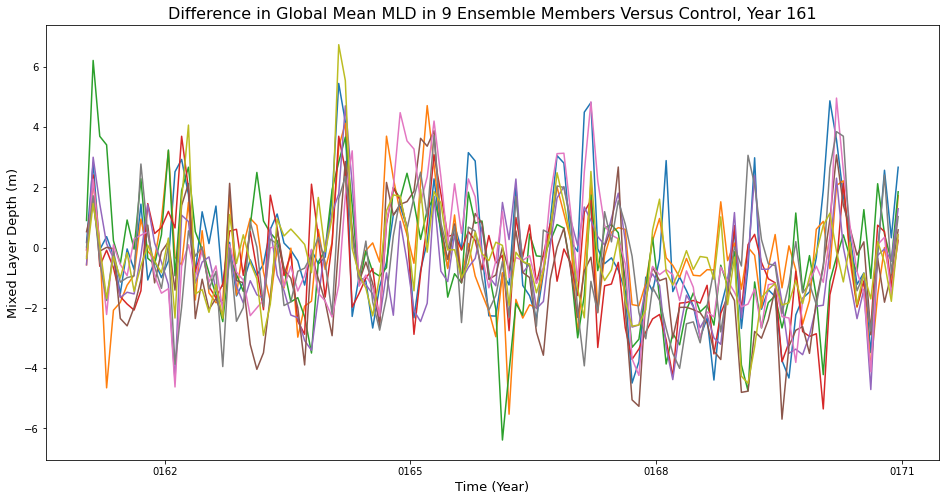

In [19]:
plot_range_all(npp_mean,npp_ens_mean,'0161','0170','Global Mean MLD of Control (Blue) and Ensembles (Red), Year 161',True,'Mixed Layer Depth (m)')
plot_anomaly(npp_mean,npp_ens_mean,'0161','0171','Difference in Global Mean MLD in 9 Ensemble Members Versus Control, Year 161',True,'Mixed Layer Depth (m)')

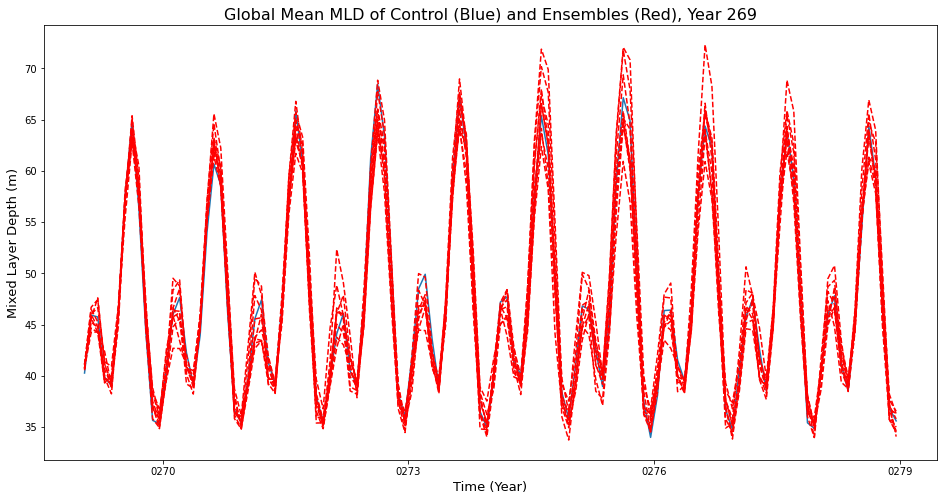

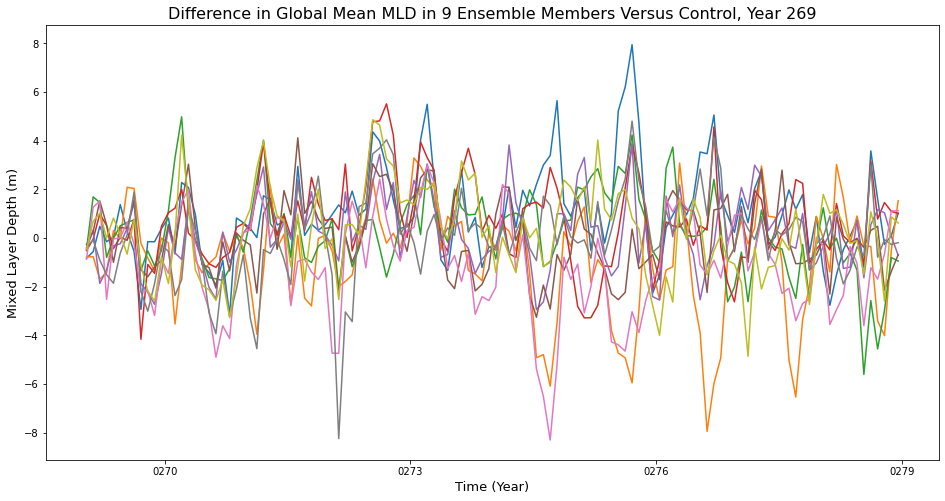

In [20]:
plot_range_all(npp_mean,npp_ens_mean,'0269','0278','Global Mean MLD of Control (Blue) and Ensembles (Red), Year 269',True,'Mixed Layer Depth (m)')
plot_anomaly(npp_mean,npp_ens_mean,'0269','0279','Difference in Global Mean MLD in 9 Ensemble Members Versus Control, Year 269',True,'Mixed Layer Depth (m)')

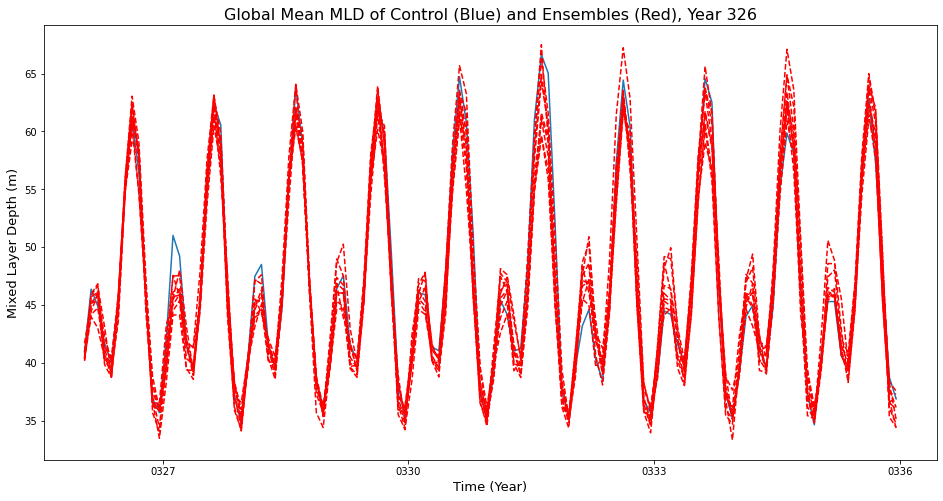

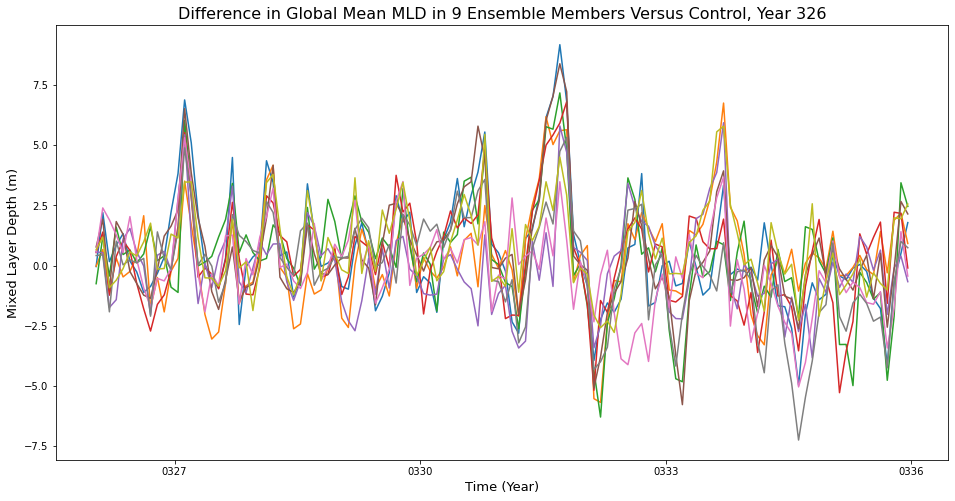

In [21]:
plot_range_all(npp_mean,npp_ens_mean,'0326','0335','Global Mean MLD of Control (Blue) and Ensembles (Red), Year 326',True,'Mixed Layer Depth (m)')
plot_anomaly(npp_mean,npp_ens_mean,'0326','0336','Difference in Global Mean MLD in 9 Ensemble Members Versus Control, Year 326',True,'Mixed Layer Depth (m)')